In [35]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency 

# Biodiversity Project

# Introduction
Suppose that I am a biodiversity analyst working for the National Parks Service.  I plan to help them analyze some data about species at various national parks.

Note: The data that we'll be working with for this project is *inspired* by real data, but is mostly fictional.

# Part 1: Reading in the data
We have been given two CSV files. `species_info.csv` with data about different species in our National Parks, including:
- The scientific name of each species
- The common names of each species
- The species conservation status

Load the dataset and inspect it:
- Load `species_info.csv` into a DataFrame called `species`

In [8]:
species = pd.read_csv('species_info.csv')

In [9]:
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


# Part 2 : Exploring our data
Let's start by learning a bit more about our data. To get an sense of our data, we'll answer the three following questions: 

- How many different species are in the `species` DataFrame?
- What are the different values of `category` in `species`?
- What are the different values of `conservation_status`?

The solutions for the above questions are listed in order below:

In [10]:
species.category.nunique()

7

In [11]:
species.category.unique()

array(['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant',
       'Nonvascular Plant'], dtype=object)

In [20]:
species.conservation_status.unique()

array(['No Intervention', 'Species of Concern', 'Endangered',
       'Threatened', 'In Recovery'], dtype=object)

# Part 3 : Analysis
Let's start doing some analysis!

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currently neither in danger of extinction throughout all or a significant portion of its range

We'd like to count up how many species meet each of these criteria.  So we will `groupby` to count how many `scientific_name` meet each of these criteria.

In [21]:
species.groupby('conservation_status').scientific_name.nunique().reset_index()

,conservation_status,scientific_name
0,Endangered,15
1,In Recovery,4
2,No Intervention,5363
3,Species of Concern,151
4,Threatened,10


As we saw before, there are far more than 200 species in the `species` table.  Clearly, only a small number of them are categorized as needing some sort of protection.  The rest have `conservation_status` equal to `None`.  Because `groupby` does not include `None`, we will need to fill in the null values.  We can do this using `.fillna`.  We pass in however we want to fill in our `None` values as an argument.

To do this, we will use the following code and run it to see replace `None` with `No Intervention`:
```python
species.fillna('No Intervention', inplace=True)
```

In [22]:
species.fillna('No Intervention', inplace = True)

Great! Now we can run the same `groupby` as before to see how many species require `No Intervention`.

In [23]:
species.groupby('conservation_status').scientific_name.nunique().reset_index()

,conservation_status,scientific_name
0,Endangered,15
1,In Recovery,4
2,No Intervention,5363
3,Species of Concern,151
4,Threatened,10


As we can see in the dataframe above, 5363 animals in our data set require no intervention. The second highest value in our table tells us there are 151 animals that our of concern. 

We want to create a bar chart to visualize our data, but first we must sort the columns by how many species are in each categories.  We can do this using `.sort_values`.  We use the the keyword `by` to indicate which column we want to sort by. This is done using the code below.

In [24]:
protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')

Now that we have done this, we can create our bar graph!

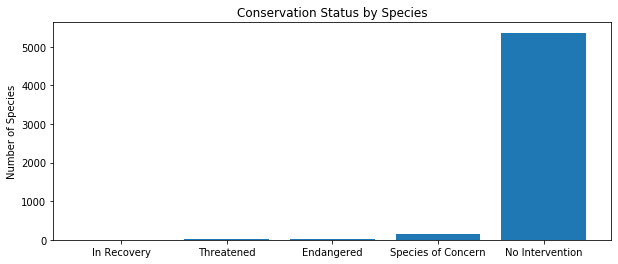

In [25]:
f, ax = plt.subplots(figsize =(10,4))
plt.bar(x= range(len(protection_counts)), 
        height = protection_counts.scientific_name.values)

ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts.conservation_status)
ax.set_ylabel('Number of Species')
ax.set_title('Conservation Status by Species')

plt.show()

# Question 
Great news, we have plotted are graph and it resembles our dataframe we created earlier. Now, we want to know 
- if there are certain types of species more likely to be endangered? 


To arrive at our answer, we will create a new column in `species` called `is_protected`, which is `True` if `conservation_status` is not equal to `No Intervention`, and `False` otherwise.

In [26]:
species['is_protected'] = species.conservation_status != 'No Intervention'

We'll group the `species` data frame by the `category` and `is_protected` columns and count the unique `scientific_name`s in each grouping.

We then save the results to `category_counts`.

In [27]:
category_counts = species.groupby(['category','is_protected']).scientific_name.nunique().reset_index()

In [28]:
category_counts.head()

,category,is_protected,scientific_name
0,Amphibian,False,72
1,Amphibian,True,7
2,Bird,False,413
3,Bird,True,75
4,Fish,False,115


It's going to be easier to view this data if we pivot it.  Using `pivot`, we'll rearange `category_counts` so that:
- `columns` is `is_protected`
- `index` is `category`
- `values` is `scientific_name`

As before, we'll save the pivoted data to `category_pivot`. 

In [29]:
category_pivot = category_counts.pivot( columns = 'is_protected',
                                       index = 'category',
                                       values = 'scientific_name').reset_index()

In [31]:
category_pivot

is_protected,category,False,True
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


Next, we'll use the `.columns` property to  rename the categories `True` and `False` to something more descriptive:

In [33]:
category_pivot.columns = ['category', 'not_protected', 'protected']

Let's create a new column of `category_pivot` called `percent_protected`, which is equal to `protected` (the number of species that are protected) divided by `protected` plus `not_protected` (the total number of species).

In [71]:
denom = category_pivot.protected + category_pivot.not_protected
category_pivot['percent_protected'] = category_pivot.protected/(denom)

Examine `category_pivot`.

In [79]:
category_pivot.sort_values(['percent_protected'],ascending=False)

,category,not_protected,protected,percent_protected
3,Mammal,146,30,0.170455
1,Bird,413,75,0.153689
0,Amphibian,72,7,0.088608
2,Fish,115,11,0.087302
5,Reptile,73,5,0.064103
4,Nonvascular Plant,328,5,0.015015
6,Vascular Plant,4216,46,0.010793


It looks like species in category `Mammal` are more likely to be endangered than species in `Bird`.  We're going to do a significance test to see if this statement is true.  Before we do the significance test, we consider the following questions:
- Is the data numerical or categorical?
- How many pieces of data are we comparing?

Based on those answers, we choose to do a *chi squared test*.  In order to run a chi squared test, we'll need to create a contingency table.  Our contingency table should look like this:

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|


In [34]:
contingency = pd.DataFrame([[30,146],[75,413]],
                           columns = ['protected','not protected'],
                           index = ['Mammal','Bird'])
contingency

,protected,not protected
Mammal,30,146
Bird,75,413


In order to perform our chi square test, we'll need to import the correct function from scipy. The following code does the trick and we have already run it:
```py
from scipy.stats import chi2_contingency
```

In [102]:
chi2_contingency(contingency)
print('The chi squared test statistic is :%1.15f' 
      %chi2_contingency(contingency)[0])
print('The p-value is :%1.15f' 
      %chi2_contingency(contingency)[1])
print('The degrees of freedom is: %1.0f' 
      %chi2_contingency(contingency)[2])

The chi squared test statistic is :0.161701483165456
The p-value is :0.687594809666134
The degrees of freedom is: 1


It looks like this difference isn't significant! Since p-value is greater than $\alpha$ =  .05, we fail to reject the null.

Let's test another.  Is the difference between `Reptile` and `Mammal` significant?

In [109]:
contingency_2 = pd.DataFrame([[30,146],[5,73]],
                           columns = ['protected','not protected'],
                           index = ['Mammal','Reptile'])
contingency_2

,protected,not protected
Mammal,30,146
Reptile,5,73


Now run `chi2_contingency` with `contingency`.

In [110]:
chi2_contingency(contingency_2)
print('The chi squared test statistic is :%1.15f' 
      %chi2_contingency(contingency_2)[0])
print('The p-value is :%1.15f' 
      %chi2_contingency(contingency_2)[1])
print('The degrees of freedom is: %1.0f' 
      %chi2_contingency(contingency_2)[2])

The chi squared test statistic is :4.289183096203645
The p-value is :0.038355590229699
The degrees of freedom is: 1


Yes! It looks like there is a significant difference between `Reptile` and `Mammal`! Since the p-value is less than $\alpha$ = .05 we reject the null and have significant evidence to conclude that there is a difference between reptile and mammal. 

# Part 4
Conservationists have been recording sightings of different species at several national parks for the past 7 days.  They've sent me their observations in a file called `observations.csv`.  We assign `observations.csv` into a variable called `observations`, then use `head` to preview the data.

In [112]:
observations = pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


A couple of the scientists are studying the number of sheep sightings at different national parks.  There are several different scientific names for different types of sheep.  We'd like to know which rows of `species` are referring to sheep.  Notice that the following code will tell us whether or not a word occurs in a string:

In [1]:
# Does "Sheep" occur in this string?
str1 = 'This string contains Sheep'
'Sheep' in str1

True

In [2]:
# Does "Sheep" occur in this string?
str2 = 'This string contains Cows'
'Sheep' in str2

False

To accomplish this task, we will use `apply` and a `lambda` function to create a new column in `species` called `is_sheep` which is `True` if the `common_names` contains `'Sheep'`, and `False` otherwise.

In [36]:
species['is_sheep'] = species.common_names.apply(lambda x: 'Sheep' in x)
species.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False


Selecting the rows of `species` where `is_sheep` is `True` we see that most of the results are actually referring to plants. We want to select the rows where the category is `Mammal`.

In [115]:
species[species.is_sheep]

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
1139,Vascular Plant,Rumex acetosella,"Sheep Sorrel, Sheep Sorrell",No Intervention,False,True
2233,Vascular Plant,Festuca filiformis,Fineleaf Sheep Fescue,No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3758,Vascular Plant,Rumex acetosella,"Common Sheep Sorrel, Field Sorrel, Red Sorrel,...",No Intervention,False,True
3761,Vascular Plant,Rumex paucifolius,"Alpine Sheep Sorrel, Fewleaved Dock, Meadow Dock",No Intervention,False,True
4091,Vascular Plant,Carex illota,"Sheep Sedge, Smallhead Sedge",No Intervention,False,True
4383,Vascular Plant,Potentilla ovina var. ovina,Sheep Cinquefoil,No Intervention,False,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


In [37]:
sheep_species = species[species.is_sheep & (species.category =='Mammal')]
sheep_species #contains all mammals where is_sheep is True

,category,scientific_name,common_names,conservation_status,is_protected,is_sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


Up next, is to merge `sheep_species` with `observations` to get a DataFrame with observations of sheep.

In [124]:
sheep_observations = observations.merge(sheep_species)
sheep_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_sheep
0,Ovis canadensis,Yellowstone National Park,219,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
1,Ovis canadensis,Bryce National Park,109,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
2,Ovis canadensis,Yosemite National Park,117,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3,Ovis canadensis,Great Smoky Mountains National Park,48,Mammal,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4,Ovis canadensis sierrae,Yellowstone National Park,67,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
5,Ovis canadensis sierrae,Yosemite National Park,39,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
6,Ovis canadensis sierrae,Bryce National Park,22,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
7,Ovis canadensis sierrae,Great Smoky Mountains National Park,25,Mammal,Sierra Nevada Bighorn Sheep,Endangered,True,True
8,Ovis aries,Yosemite National Park,126,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
9,Ovis aries,Great Smoky Mountains National Park,76,Mammal,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True


# Question One
As the word suggests, we want to go on a quest for answers, specifically, we want to know the following:
- How many total sheep observations (across all three species) were made at each national park?  

Below is the total number of sheep observed in each park over the past 7 days.

In [129]:
obs_by_park = sheep_observations.groupby('park_name').observations.sum().reset_index()
obs_by_park

,park_name,observations
0,Bryce National Park,250
1,Great Smoky Mountains National Park,149
2,Yellowstone National Park,507
3,Yosemite National Park,282


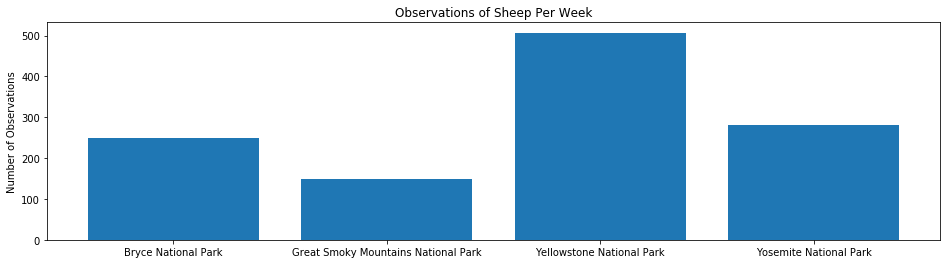

In [150]:
f,ax = plt.subplots(figsize=(16,4))

plt.bar(x= range(len(obs_by_park)), 
        height = obs_by_park.observations.values)

ax.set_xticks(range(len(obs_by_park)))
ax.set_xticklabels(obs_by_park.park_name.values)
ax.set_ylabel('Number of Observations')
ax.set_title('Observations of Sheep Per Week')


plt.show()

# Question Two

Our scientists know that 15% of sheep at Bryce National Park have foot and mouth disease.  Park rangers at Yellowstone National Park have been running a program to reduce the rate of foot and mouth disease at that park.  The scientists want to test whether or not this program is working.  They want to be able to detect reductions of at least 5 percentage points.  For instance, if 10% of sheep in Yellowstone have foot and mouth disease, they'd like to be able to know this, with confidence.

NOTE: "Minimum Detectable Effect" is a percent of the baseline.

In [38]:
minimum_detectable_effect = (100 * 0.05) / 0.15
print(minimum_detectable_effect)

baseline = 15
sample_size_per_variant = 870


33.333333333333336


How many weeks would you need to observe sheep at Bryce National Park in order to observe enough sheep?  How many weeks would you need to observe at Yellowstone National Park to observe enough sheep?

In [154]:
bryce = 870 / 250.
yellowstone = 810 / 507.

# Approximately 3.5 weeks at Bryce and 1.5 weeks at Yellowstone.